#  Régression: une introduction



<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/3_regression.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/3_regression.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/3_regression.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=%C2%ABpython-datascientist%C2%BB&resources.requests.memory=%C2%AB4Gi%C2%BB)
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=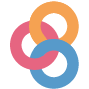)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=notebooks/course/modelisation/3_regression.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/3_regression.ipynb)

Le précédent chapitre visait à proposer un premier modèle pour comprendre
les comtés où le parti Républicain l'emporte. La variable d'intérêt étant
bimodale (victoire ou défaite), on était dans le cadre d'un modèle de 
classification.

Maintenant, sur les mêmes données, on va proposer un modèle de régression
pour expliquer le score du parti Républicain. La variable est donc continue.
Nous ignorerons le fait que ses bornes se trouvent entre 0 et 100 et donc 
qu'il faudrait, pour être rigoureux, transformer l'échelle afin d'avoir 
des données dans $\mathbb{R}$. 

Ce chapitre utilise toujours le même jeu de données, présenté dans l'[introduction
de cette partie](https://linogaliana-teaching.netlify.app/modelisation/): les données de vote aux élections présidentielles US
croisées à des variables socio-démographiques.
Le code 
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/master/content/modelisation/get_data.py)


# Principe général

Le principe général de la régression consiste à trouver une loi $h_\theta(X)$
telle que

$$
h_\theta(X) = \mathbb{E}_\theta(Y|X)
$$
Cette formalisation est extrêmement généraliste et ne se restreint d'ailleurs
par à la régression linéaire. 

En économétrie, la régression offre une alternative aux méthodes de maximum
de vraisemblance et aux méthodes de moment. La régression est un ensemble 
très vaste de méthodes, selon la famille de modèles
(paramétriques, non paramétriques, etc.) et la structure de modèles. 
En *Machine Learning* 

## La régression linéaire

C'est la manière la plus simple de représenter la loi $h_\theta(X)$ comme 
combinaison linéaire de variables $X$ et de paramètres $\theta$. Dans ce
cas, 

$$
\mathbb{E}_\theta(Y|X) = X\beta
$$

Cette relation est encore, sous cette formulation, théorique. Il convient 
de l'estimer à partir des données observées $y$. La méthode des moindres
carrés consiste à minimiser l'erreur quadratique entre la prédiction et 
les données observées (ce qui explique qu'on puisse voir la régression comme
un problème de *Machine Learning*). En toute généralité, la méthode des
moindres carrés consiste à trouver l'ensemble de paramètres $\theta$ 
tel que

$$
\theta = \arg \min_{\theta \in \Theta} \mathbb{E}\bigg[ \left( y - h_\theta(X) \right)^2 \bigg]
$$

Ce qui, dans le cadre de la régression linéaire, s'exprime de la manière suivante:

$$
\beta = \arg\min \mathbb{E}\bigg[ \left( y - X\beta \right)^2 \bigg]
$$

Lorsqu'on amène le modèle théorique ($\mathbb{E}_\theta(Y|X) = X\beta$) aux données,
on formalise le modèle de la manière suivante:

$$
Y = X\beta + \epsilon
$$

Avec une certaine distribution du bruit $\epsilon$ qui dépend
des hypothèses faites. Par exemple, avec des 
$\epsilon \sim \mathcal{N}(0,\sigma^2)$ i.i.d., l'estimateur $\beta$ obtenu
est équivalent à celui du Maximum de Vraisemblance dont la théorie asymptotique
nous assure l'absence de biais, la variance minimale (borne de Cramer-Rao).

Cet exercice vise à illustrer la manière d'effectuer une régression linéaire avec `scikit`. Dans ce domaine,
`statsmodels` est néanmoins plus complet, ce que montrera l'exercice suivant. L'intérêt de faire 
des régressions avec `scikit` est de pouvoir comparer les résultats d'une régression linéaire
avec d'autres modèles de régression.

L'objectif est d'expliquer le score des Républicains en fonction de quelques
variables

1. A partir de quelques variables, par exemple, *'Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"*, expliquer la variable `per_gop`. :warning: utiliser la variable `Median_Household_Income_2019`
en `log` sinon son échelle risque d'écraser tout effet.
2. Afficher les valeurs des coefficients, constante comprise
3. Evaluer la pertinence du modèle avec le $R^2$ et la qualité du fit avec le MSE
4. Représenter un nuage de point des valeurs observées
et des erreurs de prédiction. Observez-vous
un problème de spécification



```
## <string>:1: SettingWithCopyWarning:
## 
## 
## A value is trying to be set on a copy of a slice from a DataFrame.
## Try using .loc[row_indexer,col_indexer] = value instead
## 
## See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
```

```
## 57.59445556916607 [-3.50970996 -0.48912669 -1.38569556  5.35926698]
```

```
## Mean squared error: 12.76
```

```
## Coefficient of determination: 0.39
```



La répartition des erreurs n'est clairement pas aléatoire en fonction de $X$.
Le modèle souffre
donc d'un problème de spécification. 

Cet exercice vise à illustrer la manière d'effectuer une régression linéaire avec `statsmodels` qui offre une interface proche de celle de `R`

L'objectif est d'expliquer le score des Républicains en fonction de quelques
variables

1. A partir de quelques variables, par exemple, *'Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"*, expliquer la variable `per_gop`. :warning: utiliser la variable `Median_Household_Income_2019`
en `log` sinon son échelle risque d'écraser tout effet.
2. Afficher un tableau de régression
3. Evaluer la pertinence du modèle avec le R^2
4. Utiliser l'API `formula` pour régresser le score des républicains en fonction de la variable `Unemployment_rate_2019`, de `Unemployment_rate_2019` au carré et du log de 
`Median_Household_Income_2019`


```
## Error in py_call_impl(callable, dots$args, dots$keywords): ModuleNotFoundError: No module named 'statsmodels'
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

```
## Error in py_call_impl(callable, dots$args, dots$keywords): ModuleNotFoundError: No module named 'statsmodels'
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

```
## <string>:1: SettingWithCopyWarning:
## 
## 
## A value is trying to be set on a copy of a slice from a DataFrame.
## Try using .loc[row_indexer,col_indexer] = value instead
## 
## See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
```

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'sm' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'sm' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'results' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```


```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'smf' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'results' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

Pour sortir une belle table pour un rapport sous $\LaTeX$, il est possible d'utiliser
la méthode [`Summary.as_latex`](https://www.statsmodels.org/devel/generated/statsmodels.iolib.summary.Summary.as_latex.html#statsmodels.iolib.summary.Summary.as_latex). Pour un rapport HTML, on utilisera [`Summary.as_html`](https://www.statsmodels.org/devel/generated/statsmodels.iolib.summary.Summary.as_latex.html#statsmodels.iolib.summary.Summary.as_latex)

Les utilisateurs de `R` retrouveront des éléments très familiers avec `statsmodels`,
notamment la possibilité d'utiliser une formule pour définir une régression.
La philosophie de `statsmodels` est similaire à celle qui a présidé à la construction
des packages `stats` et `MASS` de `R`: offrir une librairie généraliste, proposant
une large gamme de modèles. Néanmoins, `statsmodels` bénéficie de sa jeunesse
par rapport aux packages `R`. Depuis les années 1990, les packages `R` visant 
à proposer des fonctionalités manquantes dans `stats` et `MASS` se sont
multipliés alors que `statsmodels`, enfant des années 2010, n'a eu qu'à
proposer un cadre général (les *generalized estimating equations*) pour
englober ces modèles.

## La régression logistique

Ce modèle s'applique à une distribution binaire.
Dans ce cas, $\mathbb{E}\_{\theta}(Y|X) = \mathbb{P}\_{\theta}(Y = 1|X)$.
La régression logistique peut être vue comme un modèle linéaire en probabilité:

$$
\text{logit}\bigg(\mathbb{E}\_{\theta}(Y|X)\bigg) = \text{logit}\bigg(\mathbb{P}\_{\theta}(Y = 1|X)\bigg) = X\beta
$$

La fonction $\text{logit}$ est $]0,1[ \to \mathbb{R}: p \mapsto \log(\frac{p}{1-p})$
permet ainsi de transformer une probabilité dans $\mathbb{R}$.
Sa fonction réciproque est la sigmoïde ($\frac{1}{1 + e^{-x}}$),
objet central du *Deep Learning*.

Il convient de noter que les probabilités ne sont pas observées, c'est l'*outcome*
binaire (0/1) qui l'est. Cela amène à voir la régression logistique de deux
manières différente:

* En économétrie, on s'intéresse au modèle latent qui détermine le choix de
l'outcome. Par exemple, si on observe les choix de participer ou non au marché
du travail, on va modéliser les facteurs déterminant ce choix ;
* En *Machine Learning*, le modèle latent n'est nécessaire que pour classifier
dans la bonne catégorie les observations

L'estimation des paramètres $\beta$ peut se faire par maximum de vraisemblance
ou par régression, les deux solutions sont équivalentes sous certaines
hypothèses. 

Par défaut, `scikit` applique une régularisation pour pénaliser les modèles
peu parcimonieux (comportement différent
de celui de `statsmodels`). Ce comportement par défaut est à garder à l'esprit
si l'objectif n'est pas de faire de la prédiction. 

Avec `scikit`, en utilisant échantillons d'apprentissage et d'estimation:

1. Evaluer l'effet des variables déjà utilisées sur la probabilité des Républicains
de gagner
2. Faire varier le paramètre de régularisation. Quel effet sur les paramètres estimés?
3. Classifier le fait que chaque comté soit ou non gagné par les Républicains en fonction du score prédit. En déduire une matrice de confusion et 
une mesure de qualité du modèle

<!--- Exercice à corriger ---->

En utilisant échantillons d'apprentissage et d'estimation:

1. Evaluer l'effet des variables déjà utilisées sur la probabilité des Républicains
de gagner
2. Faire un test de ratio de vraisemblance concernant l'inclusion de la variable de (log)-revenu 

La statistique du test est:
$$
LR = -2\log\bigg(\frac{\mathcal{L}_{\theta}}{\mathcal{L}_{\theta_0}}\bigg) = -2(\mathcal{l}_{\theta} - \mathcal{l}_{\theta_0})
$$

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'smf' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'mylogit' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'smf' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'mylogit' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'logit_h0' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'lr' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

La pvalue du test de maximum de ratio de vraisemblance étant proche de 
1, cela signifie que la variable log revenu ajoute, presque à coup sûr,
de l'information au modèle. 


## Modèles linéaires généralisés

TO BE COMPLETED

## Autres modèles de Machine Learning

TO BE COMPLETED

## Tests d'hypothèses
